In [1]:
! nvidia-smi

Fri Apr  2 16:28:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import pandas as pd
import os
from glob import glob
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')
print('I believe Bitcoin')

Mounted at /content/drive
I believe Bitcoin


In [6]:
# Install RAPIDS

!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!bash rapidsai-csp-utils/colab/rapids-colab.sh stable

import sys, os

dist_package_index = sys.path.index('/usr/local/lib/python3.7/dist-packages')
sys.path = sys.path[:dist_package_index] + ['/usr/local/lib/python3.7/site-packages'] + sys.path[dist_package_index:]
sys.path
exec(open('rapidsai-csp-utils/colab/update_modules.py').read(), globals())

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 205 (delta 16), reused 3 (delta 0), pack-reused 171
Receiving objects: 100% (205/205), 62.72 KiB | 892.00 KiB/s, done.
Resolving deltas: 100% (78/78), done.
PLEASE READ
********************************************************************************************************
Changes:
1. IMPORTANT SCRIPT CHANGES: Colab has updated to Python 3.7, and now runs our STABLE and NIGHTLY versions (0.18 and 0.19)!  PLEASE update your older install script code as follows:
	!bash rapidsai-csp-utils/colab/rapids-colab.sh 0.18

	import sys, os

	dist_package_index = sys.path.index('/usr/local/lib/python3.7/dist-packages')
	sys.path = sys.path[:dist_package_index] + ['/usr/local/lib/python3.7/site-packages'] + sys.path[dist_package_index:]
	sys.path
	exec(open('rapidsai-csp-utils/colab/update_modules.py').read(), global

In [55]:
import cudf
input_dir = '/content/drive/MyDrive/Machine_Learning/data/atma/05_sindenzu/01_input/'

train_df = pd.read_csv(os.path.join(input_dir, 'train.csv'))
test_df = pd.read_csv(os.path.join(input_dir, 'test.csv'))

data = {}

files = glob(os.path.join(input_dir, 'spectrum_raw/*.dat'))
#for p in tqdm(files, total=len(files)):
    #data[os.path.basename(p)] = cudf.read_csv(p, sep='\t', header=None)

In [56]:
def create_wave_array(meta_df: pd.DataFrame, is_power=True) -> np.ndarray:
    """
    入力された data-frame の行に対応する波形 (512次元配列) を持つ配列を作成します。
    """
    x = []
    i = 1 if is_power else 0

    for name, exc_wl in tqdm(zip(meta_df['spectrum_filename'], meta_df['exc_wl']), total=len(meta_df)):
        _df = data.get(name, None)
        assert _df is not None
        z = np.zeros(shape=(512,))

        start_i = 0
        z[start_i:len(_df) + start_i] = _df.values[:, i]
        x.append(z)
    return np.array(x)

In [89]:
x_train = pd.read_csv(os.path.join(input_dir, '行列.csv'))#create_wave_array(train_df)
y = train_df['target'].values
del x_train['Unnamed: 0']

x_train = x_train.values
x_test = pd.read_csv(os.path.join(input_dir, '行列_test.csv'))
del x_test['Unnamed: 0']
x_test  = x_test.values

In [90]:
x_test

array([[ 3.000e+01, -9.100e+01, -1.480e+02, ..., -3.700e+01,  1.600e+01,
         1.780e+02],
       [ 6.000e+00,  6.300e+01, -2.020e+02, ..., -2.800e+01, -5.200e+01,
         0.000e+00],
       [ 2.170e+02,  5.800e+01, -1.600e+01, ..., -1.660e+02,  2.900e+02,
         0.000e+00],
       ...,
       [ 1.660e+02,  2.340e+02, -1.000e+00, ..., -1.830e+02,  2.300e+02,
         0.000e+00],
       [ 4.990e+02,  7.440e+02,  7.820e+02, ...,  2.930e+02,  3.070e+02,
         2.480e+02],
       [-4.900e+01,  2.070e+02,  1.670e+02, ...,  2.032e+03,  2.036e+03,
         0.000e+00]])

In [91]:
print('before: {}'.format(x_train.shape))
x_train = x_train[:, :, None, None]
print('after: {}'.format(x_train.shape))

before: (7436, 512)
after: (7436, 512, 1, 1)


In [107]:
x_test = x_test[:, :, None, None]

In [93]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 学習時に使う generator. 
# featurewise_std_normalization でデータセット全体で正規化 + height (i.e. 512次元の方向) にちょっとずらす shift を行なう
# vertical_flip(波形方向に反転)は試したのですがしないほうがCVが良かったため採用していません
gen = ImageDataGenerator(vertical_flip=False,  
                         featurewise_std_normalization=True,
                         height_shift_range=.05)

# validation の時に使う generator
# こちらは validation に使うのでデータの変更は行わない 
# (ただし正規化のスケールは合わせないと train とずれるので featurewise の正規化だけかける) 
valid_gen = ImageDataGenerator(
    featurewise_std_normalization=True,
    vertical_flip=False, 
    height_shift_range=0
)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:349: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


In [94]:
# featurewize の正規化を学習させる
gen.fit(x_train)
valid_gen.fit(x_train)

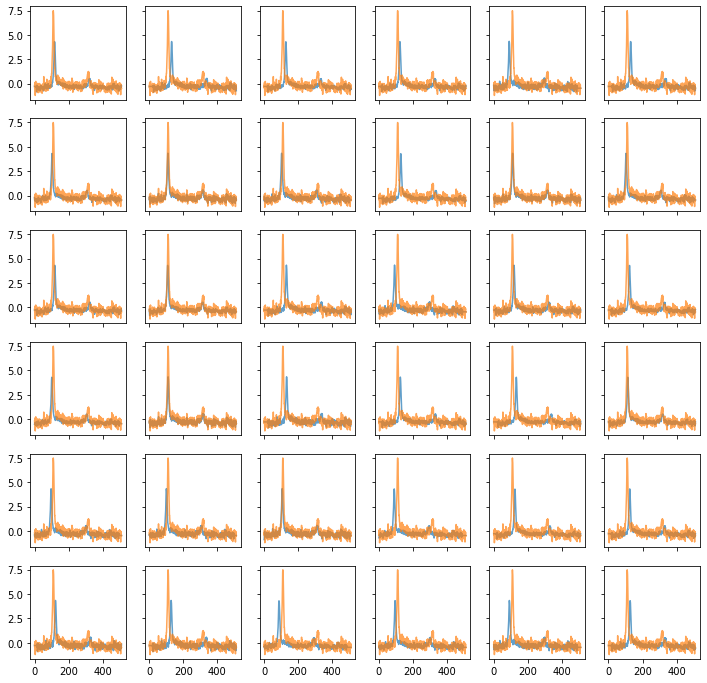

In [95]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
sample_idx = 20

x_train_sample = np.array([x_train[sample_idx] for _ in range(1000)])
for x_batch, y_batch in gen.flow(x_train_sample, y[:1000], batch_size=36):
    break

fig, axes = plt.subplots(figsize=(12, 12), ncols=6, nrows=6, sharex=True, sharey=True)
for x, ax in zip(x_batch, np.ravel(axes)):
    ax.plot(x.reshape(-1), alpha=.7)

    # 元の波形は正規化されてないので便宜的に samplewize に normalize する (本当はデータ全体で正規化するのでちょっとずれてる)
    ax.plot(scaler.fit_transform(x_train[sample_idx].reshape(-1, 1))[:, 0], alpha=.7)

In [96]:
from keras.models import Model
from keras.layers import Dense, Input, BatchNormalization, ReLU, Flatten
from keras.layers import Reshape, Conv1D, MaxPool1D, Input, BatchNormalization, ReLU, Flatten, Dense, GlobalMaxPool1D

def conv_layer(x, n_channels=32, kernel_size=3, pool_size=2, padding='same'):
    x = Conv1D(filters=n_channels, kernel_size=kernel_size, padding=padding)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPool1D(pool_size=pool_size, padding='same')(x)
    return x

def conv1d_network(n_inputs=512, n_output=1):
    input_tensor = Input(shape=(n_inputs, 1, 1))
    x = Reshape((n_inputs, 1))(input_tensor)
    x = conv_layer(x, 8, 5, 2)
    x = conv_layer(x, 32, 5, 2)
    x = conv_layer(x, 64, 5, 2)
    x = conv_layer(x, 128)
    # 今回単純化のためにこれより下はコメントアウトしています。
    # GPU ON の時はコメントアウト外して実行してみてください
    x = conv_layer(x, 256)
    x = conv_layer(x, 512)
    x = conv_layer(x, 1024)
    x = conv_layer(x, 2048)
    x = GlobalMaxPool1D()(x)
    out = Dense(n_output, activation='sigmoid')(x)
    return Model(input_tensor, outputs=out, name='conv1d')


In [97]:
model_conv = conv1d_network(512, 1)
model_conv.summary()

Model: "conv1d"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 512, 1, 1)]       0         
_________________________________________________________________
reshape_13 (Reshape)         (None, 512, 1)            0         
_________________________________________________________________
conv1d_104 (Conv1D)          (None, 512, 8)            48        
_________________________________________________________________
batch_normalization_104 (Bat (None, 512, 8)            32        
_________________________________________________________________
re_lu_104 (ReLU)             (None, 512, 8)            0         
_________________________________________________________________
max_pooling1d_104 (MaxPoolin (None, 256, 8)            0         
_________________________________________________________________
conv1d_105 (Conv1D)          (None, 256, 32)           1312 

In [98]:
#Customu cal back
from keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler
from sklearn.metrics import average_precision_score

class PRAUCCallback(Callback):
    def __init__(self, valid_flow, y):
        super(PRAUCCallback, self).__init__()
        self.valid_flow = valid_flow
        self.y = y

    def on_epoch_end(self, epoch, logs=None):
        y_pred = self.model.predict(valid_flow).reshape(-1)#かえた
        score = average_precision_score(self.y, y_pred)
        print(f'PR AUC: {score:4f}')
        logs['val_pr-auc'] = score
        return

    def on_batch_begin(self, batch, logs=None):
        return

    def on_batch_end(self, batch, logs=None):
        return

In [99]:
# Loss Schedule
def get_lr(epoch):
    if epoch < 20:
        return 1e-3

    return 1e-4

In [100]:
from sklearn.model_selection import StratifiedKFold, GroupKFold

def get_cv_byname(name='stratified'):
    if name == 'stratified':
        fold = StratifiedKFold(n_splits=5, random_state=71, shuffle=True)
        return list(fold.split(x_train, y))

    if name == 'group':
        fold = GroupKFold(n_splits=5)
        cv = list(fold.split(x_train, y, train_df['chip_id']))
        return cv


In [101]:
from keras.models import load_model
from sklearn.utils.class_weight import compute_class_weight

# inbalance の対応としてクラスの重みを計算して, positive に大きな重みをもたせる
class_weight = compute_class_weight('balanced', np.unique(y), y)
print('class weight: {}'.format(class_weight))

class weight: [ 0.51638889 15.75423729]


/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 0 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [102]:
oof = np.zeros_like(y).astype(float)
n_batch = 128
cv_name = 'group'
use_best_model = True
models = []

print(f'CV Strategy: {cv_name}')
print(f'Use Best Model {use_best_model}')

cv = get_cv_byname(cv_name)

for i, (idx_tra, idx_val) in enumerate(cv):
    print(f'start FOLD={i + 1}')
    
    train_flow = gen.flow(x_train[idx_tra], y[idx_tra], batch_size=n_batch)
    valid_flow = valid_gen.flow(x_train[idx_val], y[idx_val], batch_size=n_batch, shuffle=False)
    
    model_i = conv1d_network()
    model_i.compile(loss='binary_crossentropy', optimizer='adam')
    
    model_i.fit(train_flow, 
                #steps_per_epoch=len(x_train) / n_batch, 
                validation_data=valid_flow,
                epochs=30, 
                #class_weight=class_weight,
                callbacks=[
                    PRAUCCallback(valid_flow, y=y[idx_val]),
                    ModelCheckpoint(filepath=f'./fold_{i}.hdf5', verbose=1, mode='min',
                                    save_best_only=True, monitor='val_loss', save_freq='epoch'),
                    LearningRateScheduler(get_lr)
                    
                ])
    
    if use_best_model:
        model_i = load_model(f'./fold_{i}.hdf5')
    pred_i = model_i.predict_generator(valid_flow).reshape(-1)
    oof[idx_val] = pred_i
    models.append(model_i)
    score = average_precision_score(y[idx_val], pred_i)
    print(f'Current Fold PR-AUC: {score:.4f}')

CV Strategy: group
Use Best Model True
start FOLD=1
Epoch 1/30
44/44 [==============================] - 4s 36ms/step - loss: 0.2327 - val_loss: 0.3083
PR AUC: 0.282132

Epoch 00001: val_loss improved from inf to 0.30831, saving model to ./fold_0.hdf5
Epoch 2/30
44/44 [==============================] - 1s 29ms/step - loss: 0.0444 - val_loss: 0.3248
PR AUC: 0.291527

Epoch 00002: val_loss did not improve from 0.30831
Epoch 3/30
44/44 [==============================] - 1s 28ms/step - loss: 0.0582 - val_loss: 0.4176
PR AUC: 0.234702

Epoch 00003: val_loss did not improve from 0.30831
Epoch 4/30
44/44 [==============================] - 1s 30ms/step - loss: 0.0343 - val_loss: 0.2814
PR AUC: 0.644352

Epoch 00004: val_loss improved from 0.30831 to 0.28135, saving model to ./fold_0.hdf5
Epoch 5/30
44/44 [==============================] - 1s 29ms/step - loss: 0.0269 - val_loss: 0.1594
PR AUC: 0.661598

Epoch 00005: val_loss improved from 0.28135 to 0.15943, saving model to ./fold_0.hdf5
Epoch 6

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Current Fold PR-AUC: 0.8487
start FOLD=2
Epoch 1/30
44/44 [==============================] - 4s 36ms/step - loss: 0.1778 - val_loss: 0.2259
PR AUC: 0.059174

Epoch 00001: val_loss improved from inf to 0.22586, saving model to ./fold_1.hdf5
Epoch 2/30
44/44 [==============================] - 1s 27ms/step - loss: 0.0927 - val_loss: 0.2970
PR AUC: 0.077139

Epoch 00002: val_loss did not improve from 0.22586
Epoch 3/30
44/44 [==============================] - 1s 29ms/step - loss: 0.0413 - val_loss: 0.1310
PR AUC: 0.347087

Epoch 00003: val_loss improved from 0.22586 to 0.13096, saving model to ./fold_1.hdf5
Epoch 4/30
44/44 [==============================] - 1s 28ms/step - loss: 0.0530 - val_loss: 0.3652
PR AUC: 0.152658

Epoch 00004: val_loss did not improve from 0.13096
Epoch 5/30
44/44 [==============================] - 1s 28ms/step - loss: 0.0783 - val_loss: 0.4257
PR AUC: 0.219746

Epoch 00005: val_loss did not improve from 0.13096
Epoch 6/30
44/44 [==============================] - 1

In [109]:
scores = []
for _, idx_val in cv:
    scores.append(average_precision_score(y[idx_val], oof[idx_val]))

print('=' * 20 + 'Out-Of-Fold Score' + '=' * 20)
print(np.mean(scores), np.std(scores))

test_flow = valid_gen.flow(x_test, shuffle=False, batch_size=128)

pred = []
for model in models:
    pred.append(model.predict(test_flow))
pred = np.mean(pred, axis=0)[:, 0]

====================Out-Of-Fold Score====================
0.836711163310756 0.06399928356639174


In [106]:
x_test.shape

(6952, 512)

In [111]:
sub_df = pd.DataFrame()
sub_df['target'] = pred
sub_df.to_csv('/content/drive/MyDrive/Machine_Learning/data/atma/05_sindenzu/02_model/01_wavenet_try/submission.csv', index=False)